# Introduction

We took up a scenario of UPS or amazon like delivery systems and tried to simulate various factors that can affect the number of orders delivered on time and the time taken. So any logistics company will have n number of deliveries to be made in a day how can they ensure all the deliveries are being completed in a day for sure. 

Our project works on devising strategies that can ensure that the delivery efficiency per day is high

# Code

## Importing all the required libraries

In [7]:
import osmnx as osmnx
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import beta
import time
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import os
from scipy.stats import beta
import random

## Utility Functions

In [8]:
def initializing_graph(place_name: str, hypothesis: int) -> nx.MultiDiGraph:
    '''
    Intializing the street network graph for a place and then adding speed attribute to edge. For hypothesis 2 after adding speed to edge, the graph is returned but for hypothesis 1 base speeds of truck A and B are set and then the graph is returned.

    Args:
    place_name(str) : string defining the place name for which the graph is required.
    hypothesis(int): integer value representing the hypothesis number

    Returns:
        nx.MultiDiGraph: The initialized street network graph with speed attribute added to the edge for hypothesis 2 and for hypothesis 1 speed of truck A and truck B is also added.
     
    Doctests:
    >>> g = initializing_graph("Piedmont, California, USA", 1)
    Initializing the street network for: Piedmont, California, USA
    Graph initialization is complete!
    >>> isinstance(g, nx.MultiDiGraph)
    True

    >>> initializing_graph("Piedmont, California, USA", 3)
    Initializing the street network for: Piedmont, California, USA
    Invalid hypothesis number. Please choose either 1 or 2.


    '''

    print("Initializing the street network for:", place_name)
    Graph = osmnx.graph_from_place(place_name, network_type='drive')
    Graph = osmnx.add_edge_speeds(Graph)
    #Graph = osmnx.add_edge_travel_times(Graph)
   
    #For every edge in the graph u: The source node, v: The target node, k: The key differentiating multiple edges between u and v, data: A dictionary containing attributes of the edge, such as length, speed limit, etc.
    if hypothesis==1 or hypothesis==2:
      for u, v, k, data in Graph.edges(keys=True, data=True):
        if(hypothesis==2):
          base_speed=data.get("speed_kph", 30)#if no speed is found then speed is assumed as 30kph.
          data["speed_kph"] = base_speed
        
        elif(hypothesis==1):
           # Setting base speeds for Truck A and Truck B
          base_speed_b = data.get("speed_kph", 50)  # if no speed is found from the network graph then default speed for Truck B is 50kph.
          data["speed_truck_b"] = base_speed_b
          data["speed_truck_a"] = max(base_speed_b - 10, 10)  # Assuming that the Truck A is slower than truck B by 16 kph
      print("Graph initialization is complete!")
      return Graph
    else:
      print("Invalid hypothesis number. Please choose either 1 or 2.")
      return None

In [9]:
def apply_traffic_congestion(Graph:nx.MultiDiGraph,hypothesis: int, traffic_impact_probability:float=0.3)-> netx.MultiDiGraph: 

    '''
    Calculating the traffic congestion factor and applying it to the graph. For hypothesis 1, applying congestion factor to both truck A and truck B speed. For hypothesis 2 directly applying congestion factor to speed.

    Args:
    Graph(nx.MultiDiGraph) : The network graph of the location
    hypotheis (int): the hypotheis number 
    traffic_impact_probability (float): The probability of applying traffic congestion to roads.

    Returns:
    netx.MultiDiGraph: The graph with traffic congestion applied to the speed.

    Doctests-
    
        >>> G = nx.MultiDiGraph()
        >>> G.add_edge(1, 2, key=0, length=100, speed_kph=60, speed_truck_b=50, speed_truck_a=40)
        0

        >>> random.seed(42)  # Set seed for predictable output
        >>> beta.random_state = 42
        >>> updated_G = apply_traffic_congestion(G, hypothesis=2, traffic_impact_probability=1.0)
        Traffic congestion applied!
        >>> round(updated_G[1][2][0]['speed_kph'], 2)
        np.float64(38.78)

    '''
  
    #For every edge in the graph u: The source node, v: The target node, k: The key differentiating multiple edges between u and v, data: A dictionary containing attributes of the edge, such as length, speed limit, etc.
    for u, v, k, data in Graph.edges(keys=True, data=True):
        if random.random() < traffic_impact_probability:  # Applying congestion to roads, random.random() generates number between 0.0(inclusive) and 1.0(exclusive)
           '''
           PERT distribution:
           α: The distribution is skewed to the right, with more probability mass concentrated towards higher values.
           β: The distribution is skewed to the left, with more probability mass concentrated towards lower values.
           loc (location parameter): 0. This shifts the distribution to start at 0.
           scale (scale parameter): 1. This scales the distribution to fit within the interval [0, 1].
           The distribution will be slightly skewed to the left and will be more close to 0 than 1.
            '''
           traffic_congestion_factor = beta.rvs(2, 5, loc=0, scale=1)  # Generate traffic factor using PERT distribution.

           if hypothesis == 2:
             data["speed_kph"] = data["speed_kph"] * (1 - traffic_congestion_factor)

           elif hypothesis == 1:
             # Adjust speeds based on traffic factor
             data["speed_truck_b"] =data["speed_truck_b"]* (1 - traffic_congestion_factor)
             data["speed_truck_a"] =data["speed_truck_a"]* (1 - traffic_congestion_factor)

             # Ensure speed is  realistic
             data["speed_truck_b"] = max(data["speed_truck_b"], 5)
             data["speed_truck_a"] = max(data["speed_truck_a"], 5)

             # Calculate travel times for Truck A and Truck B
             distance = data.get("length", 1)
             distance = distance / 1000
             data["travel_time_truck_a"] = (distance / data["speed_truck_a"])
             data["travel_time_truck_b"] = (distance / data["speed_truck_b"])
           else :
            print("Invalid hypothesis number. Please choose either 1 or 2.")
            return None

    print("Traffic congestion applied!")
    return Graph

In [10]:
def get_fixed_hub_and_scc(Graph:nx.MultiDiGraph)-> tuple[nx.MultiDiGraph,int]:
    '''
     Extracting a strongly connected component- in a directed graph, where any two nodes have a directed path in between them. We didn't want to have any unreahable nodes in the graph.

     Args:
     Graph(netx.MultiDiGraph) : network graph of location

     returns:
     tuple(netx.MultiDiGraph,int):
      netx.MultiDiGraph: Strongly connected graph
      int: hub node
    '''
    hub_node = list(Graph.nodes)[0]

    print("Extracting largest strongly connected graph")
    if not nx.is_strongly_connected(Graph):
        components = nx.strongly_connected_components(Graph)
        for component in components:
            if hub_node in component:
                Graph_scc = Graph.subgraph(component).copy()
                print(f"Strongly connected component with hub node contains {len(Graph_scc.nodes)} nodes.")
                return Graph_scc, hub_node
    else:
        print("The entire graph is strongly connected.")
        return Graph, hub_node

In [11]:
def precompute_shortest_paths(Graph:nx.MultiDiGraph, hub_node:int):
    '''
    Finding out the nearest node from hub

    Args:
    Graph(netx.MultiDiGraph):Graph of location
    hub_node(int): the hub/warehouse from where the trucks will pick up parcels

    return:
    dictionary: shortest path from hub to all nodes in the graph



    '''
    shortest_paths = nx.single_source_dijkstra_path_length(Graph, hub_node, weight="length")
    return shortest_paths

In [12]:
def generate_delivery_points(Graph, num_deliveries, hub_node, shortest_paths):

    '''
    Randomly generating delivery points.
    Args:
    Graph(netx.MultiDiGraph):network Graph of location
    num_deliveries(int): number of delivery points to be generated
    hub_node(int): the hub/warehouse from where the trucks will pick up parcels

    return:
    list: list of delivery points
    >>> g = initializing_graph("Piedmont, California, USA", 1)
    >>> G, hub = get_fixed_hub_and_scc(g)
    >>> shortest_paths = precompute_shortest_paths(G,hub)
    >>> delivery_points = generate_delivery_points(G,10,hub,shortest_paths)
    >>> hub not in delivery_points
    True
    >>> len(delivery_points) == min(10, len([node for node in G.nodes if node in shortest_paths and node != hub]))
    True
    '''
    reachable_nodes = [node for node in Graph.nodes if node in shortest_paths]
    reachable_nodes.remove(hub_node)
    delivery_points = random.sample(reachable_nodes, min(num_deliveries, len(reachable_nodes)))
    print("Generated", len(delivery_points)," reachable delivery points.")
    return delivery_points

## Hypothesis 1

#### Null Hypothesis:
2 smaller trucks (B) working simultaneously will be reliably better able to deliver more packages on time per day than using 1 larger (A) truck

#### Alternate Hypothesis:
The larger (A) truck working will be reliably better able to deliver more packages on time per day than using 2 smaller trucks (B) simultaneously.

In [13]:
def plan_routes(G, hub_node, delivery_points, time_limit, truck_type, truck_capacity):
    """
    Plans delivery routes using a greedy approach.

    Args:
        G (networkx.Graph): The road network graph.
        hub_node (int): The hub node ID.
        delivery_points (list): List of delivery point node IDs.
        time_limit (float): Time limit for deliveries (in hours).

    Returns:
        completed_deliveries (int): Number of completed deliveries.
        total_time (float): Total time taken for deliveries (in hours).
    """ 
    remaining_locations = delivery_points.copy()
    total_time = 0
    completed_deliveries = 0
    current_node = hub_node

    while remaining_locations:
        # Implementation of Exception Handling 
        try:
            next_node = min(remaining_locations, key=lambda x: nx.shortest_path_length(G, source=current_node, target=x, weight='length')) ## Implementation of lambda functions 
            remaining_locations.remove(next_node) #Removing the node we visit from the list
            shortest_path = nx.shortest_path(G, source=current_node, target=next_node, weight='length') # Listing the route from current to next node
            path_time = 0
            # for loop to calculate total time taken to travel to current to next node 
            for i in range(len(shortest_path) - 1):
                u, v = shortest_path[i], shortest_path[i + 1]
                edge_data = G.get_edge_data(u, v, default={})
                edge_length = edge_data[0]['length']
                if truck_type == 'Truck A (Large)':
                    speed = edge_data[0]['speed_truck_a']
                elif truck_type == 'Truck B1 (Small)' or truck_type=='Truck B2 (Small)':
                    speed = edge_data[0]['speed_truck_a'] 
                else:
                    return "Invalid Truck Type given"
                if isinstance(speed, list): 
                    speed = float(speed[0])
                path_time += (edge_length / 1000) / speed
            total_time += path_time
            # time limit condition check  
            if total_time > time_limit:
                print("Time limit exceeded. Ending deliveries.")
                break
            completed_deliveries += 1
            current_node = next_node 
        except nx.NetworkXNoPath:
            print(f"No path between {current_node} and {next_node}. Skipping.")
            break
        if completed_deliveries==truck_capacity:
            shortest_path = nx.shortest_path(G, source=current_node, target=hub_node, weight='length')
            for i in range(len(shortest_path) - 1):
                u, v = shortest_path[i], shortest_path[i + 1]
                edge_data = G.get_edge_data(u, v, default={})
                edge_length = edge_data[0]['length']  
                speed = edge_data[0]['speed_kph'] 
                if isinstance(speed, list): 
                    speed = float(speed[0])
                path_time += (edge_length / 1000) / speed
            total_time += path_time
            current_node = hub_node
    return completed_deliveries, total_time

In [14]:
# Plot comparison graph
def plot_comparison_efficiency(x_orders, truck_a_percentages, truck_b_percentages):
    plt.plot(x_orders, truck_a_percentages, label="Truck A (Large)", color="blue", marker="o")
    plt.plot(x_orders, truck_b_percentages, label="Truck B (Max of B1 and B2)", color="green", marker="x")
    plt.xlabel("Number of Orders")
    plt.ylabel("Percentage of Orders Completed (%)")
    plt.title("Percentage of Orders Completed Within Time Limit")
    plt.legend()
    plt.grid()
    plt.show()

def plot_comparison_time(x_orders, truck_a_time, truck_b_time):
    plt.plot(x_orders, truck_a_time, label="Truck A (Large)", color="blue", marker="o")
    plt.plot(x_orders, truck_b_time, label="Truck B (Max of B1 and B2)", color="green", marker="x")
    plt.xlabel("Number of Orders")
    plt.ylabel("Time taken to deliver all orders")
    plt.title("Comparison of time taken to deliver order by small and big truck")
    plt.legend()
    plt.grid()
    plt.show()

In [15]:
def run_monte_carlo_simulation(place_name, initial_deliveries, num_simulations, increment, time_limit):
    print("Starting Monte Carlo Simulation...")
    G = initializing_graph(place_name, 1)
    G = apply_traffic_congestion(G, 1)
    G_scc, hub_node = get_fixed_hub_and_scc(G)

    shortest_paths = precompute_shortest_paths(G_scc, hub_node)
    
    x_orders = []
    truck_a_percentages = []
    truck_b_percentages = []
    truck_a_time = []
    truck_b_time = []

    num_deliveries = initial_deliveries

    for simulation in range(1, num_simulations + 1):
        print(f"\nSimulation {simulation}: Running with {num_deliveries} deliveries...")
        delivery_points = generate_delivery_points(G_scc, num_deliveries, hub_node,shortest_paths)

        # Truck capacities: Large Truck (200), Small Trucks (100 each)
        completed_del_a,total_time_a = plan_routes(G, hub_node, delivery_points, time_limit, "Truck A (Large)", 200)
        completed_del_b1,total_time_b1 = plan_routes(G_scc, hub_node, delivery_points[:len(delivery_points) // 2], time_limit,  "Truck B1 (Small)",100)
        completed_del_b2,total_time_b2 = plan_routes(G_scc, hub_node, delivery_points[:len(delivery_points) // 2], time_limit,  "Truck B2 (Small)",100)
        
        total_time_b = max(total_time_b1, total_time_b2)
        completed_del_b = completed_del_b1 + completed_del_b2

        # Calculate percentages based on deliveries completed within the time limit
        truck_a_percentage = (completed_del_a / num_deliveries) * 100
        truck_b_percentage = (completed_del_b / num_deliveries) * 100

        truck_a_percentages.append(truck_a_percentage)
        truck_b_percentages.append(truck_b_percentage)
        truck_a_time.append(total_time_a)
        truck_b_time.append(total_time_b)
        x_orders.append(num_deliveries)
        num_deliveries += increment

    plot_comparison_efficiency(x_orders, truck_a_percentages, truck_b_percentages)
    plot_comparison_time(x_orders,truck_a_time,truck_b_time)
    return truck_a_percentages, truck_b_percentages, truck_a_time, truck_b_time


In [18]:
place_name = "Champaign, Illinois, USA"
initial_deliveries = 250
num_simulations = 3
increment = 250
time_limit = 9

Starting Monte Carlo Simulation...
Initializing the street network for: Champaign, Illinois, USA
Graph initialization is complete!
Traffic congestion applied!
Extracting largest strongly connected graph
Strongly connected component with hub node contains 2234 nodes.

Simulation 1: Running with 250 deliveries...
Generated 250  reachable delivery points.

Simulation 2: Running with 500 deliveries...
Generated 500  reachable delivery points.

Simulation 3: Running with 750 deliveries...
Generated 750  reachable delivery points.


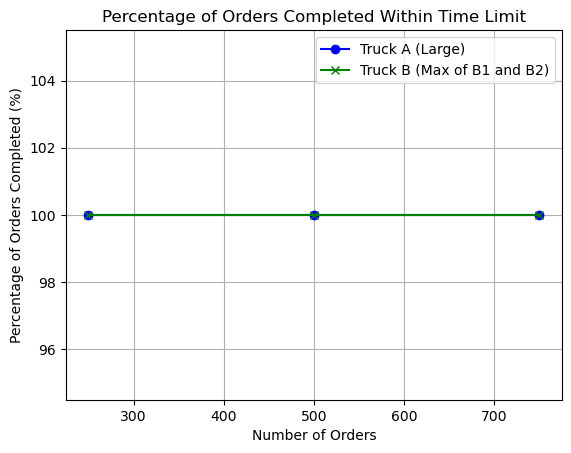

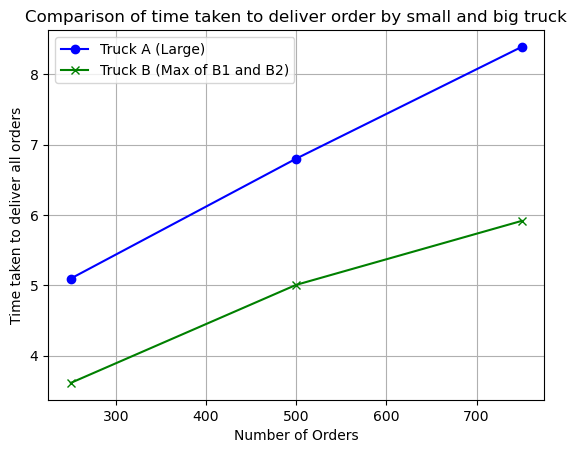

In [22]:
truck_a_percentages, truck_b_percentages, truck_a_time, truck_b_time = run_monte_carlo_simulation(
        place_name, initial_deliveries, num_simulations, increment, time_limit
    )

## Hypothesis 2

The total time taken for completing deliveries is less using the travelling salesman problem route optimization approach than greedy route strategy but the as the number of deliveries volume increases the travelling sales problem approach takes a lot of computation time

In [23]:
def plan_routes_with_greedy(G, hub_node, delivery_points, time_limit):
    """
    Plans delivery routes using a greedy approach.

    Args:
        G (networkx.Graph): The road network graph.
        hub_node (int): The hub node ID.
        delivery_points (list): List of delivery point node IDs.
        time_limit (float): Time limit for deliveries (in hours).

    Returns:
        completed_deliveries (int): Number of completed deliveries.
        total_time (float): Total time taken for deliveries (in hours).
    """ 
    remaining_locations = delivery_points.copy()
    total_time = 0
    completed_deliveries = 0
    current_node = hub_node

    while remaining_locations:
        # Implementation of Exception Handling 
        try:
            next_node = min(remaining_locations, key=lambda x: nx.shortest_path_length(G, source=current_node, target=x, weight='length')) ## Implementation of lambda functions 
            remaining_locations.remove(next_node) #Removing the node we visit from the list
            shortest_path = nx.shortest_path(G, source=current_node, target=next_node, weight='length') # Listing the route from current to next node
            path_time = 0
            # for loop to calculate total time taken to travel to current to next node 
            for i in range(len(shortest_path) - 1):
                u, v = shortest_path[i], shortest_path[i + 1]
                edge_data = G.get_edge_data(u, v, default={})
                edge_length = edge_data[0]['length']  
                speed = edge_data[0]['speed_kph'] 
                if isinstance(speed, list): 
                    speed = float(speed[0])
                path_time += (edge_length / 1000) / speed
            total_time += path_time
            # time limit condition check  
            if total_time > time_limit:
                print("Time limit exceeded. Ending deliveries.")
                break
            completed_deliveries += 1
            current_node = next_node 
        
        except nx.NetworkXNoPath:
            print(f"No path between {current_node} and {next_node}. Skipping.")
            break
    return completed_deliveries, total_time

In [24]:
def remove_all_duplicates(path):
    """Removes all duplicates while preserving the order of traversal.
    >>> l = remove_all_duplicates([12323,12344,12675,16734,12344, 16734])
    >>> len(l) == len([12323,12344,12675,16734,12344, 16734])
    False
    >>> s = set([12323,12344,12675,16734,12344, 16734])
    >>> len(s)==len(l)
    True
    """
    visited = set()
    unique_path = []
    for node in path:
        if node not in visited:
            visited.add(node)
            unique_path.append(node)
    return unique_path

In [25]:
def solve_tsp_and_calculate_deliveries(G, hub, delivery_points, time_limit, weight='length'):
    """
    Implements TSP approach to get the optimal route to cover all the delivery locations and calculates deliveries and travel time.

    Args:
        G (networkx.Graph): City graph with travel distances and speeds.
        hub (int): Hub node ID.
        delivery_points (list): List of delivery point node IDs.
        time_limit (float): Time limit for deliveries (in hours).
        weight (str): Weight attribute for calculating distances.

    Returns:
        total_time (float): Total travel time in hours.
        completed_deliveries (int): Number of deliveries completed.
        tsp_path (list): The TSP route including the hub.
    """
    tsp_nodes = [hub] + delivery_points
    complete_graph = nx.complete_graph(tsp_nodes)
    # creates a complete graph with all the nodes where delivery has to be made 

    # calculating the distance between two nodes and assiging it to the edge weight 
    for u, v in complete_graph.edges():
        try:
            path_length = nx.shortest_path_length(G, u, v, weight=weight)
            complete_graph[u][v]['weight'] = path_length
        except nx.NetworkXNoPath:
            complete_graph[u][v]['weight'] = float('inf')  
    try:
        # running the tsp algorithm to find the optimal route to traverse all the delivery points 
        tsp_path = nx.approximation.traveling_salesman_problem(complete_graph, cycle=True)
    except nx.NetworkXError:
        print("[ERROR] TSP could not be solved.")
        return None, None, None
    
    tsp_path_unique = remove_all_duplicates(tsp_path)
    total_time = 0  
    completed_deliveries = 0
    for i in range(len(tsp_path_unique) - 1):
        u, v = tsp_path_unique[i], tsp_path_unique[i + 1]
        try:
            shortest_path = nx.shortest_path(G, u, v, weight=weight)
            for j in range(len(shortest_path) - 1):
                segment_u, segment_v = shortest_path[j], shortest_path[j + 1]
                edge_data = G.get_edge_data(segment_u, segment_v, default={})
                path_length = edge_data[0][weight]
                max_speed = edge_data[0]['speed_kph'] 
                if isinstance(max_speed, list):
                    max_speed = float(max_speed[0])
                travel_time = (path_length / 1000) / max_speed
                total_time += travel_time
                if total_time > time_limit:
                    print("Time limit exceeded. Ending deliveries.")
                    return total_time, completed_deliveries, tsp_path_unique
            if v in delivery_points:
                completed_deliveries += 1
        except nx.NetworkXNoPath:
            print(f"No path between {u} and {v}. Skipping segment.")
            continue
    return total_time, completed_deliveries, tsp_path

In [26]:
def run_single_simulation(strategy, G_scc, hub_node, delivery_points, time_limit):
    if strategy == "greedy":
        start_time = time.time()
        completed_deliveries, total_time = plan_routes_with_greedy(G_scc, hub_node, delivery_points, time_limit)
        computation_time = time.time() - start_time
        return {
            "strategy": "greedy",
            "num_deliveries":len(delivery_points),
            "completed_deliveries": completed_deliveries,
            "total_time": total_time,
            "computation_time": computation_time,
        }
    elif strategy == "tsp":
        start_time = time.time()
        total_time, completed_deliveries, _ = solve_tsp_and_calculate_deliveries(G_scc, hub_node, delivery_points, time_limit)
        computation_time = time.time() - start_time
        return {
            "strategy": "tsp",
            "num_deliveries":len(delivery_points),
            "completed_deliveries": completed_deliveries,
            "total_time": total_time,
            "computation_time": computation_time,
        }
    else:
        raise ValueError("Invalid strategy. Use 'greedy' or 'tsp'.")


In [39]:
def simulation_hypothesis_2(G, num_deliveries, time_limit, iterations):
    """
    Runs simulations in parallel for Greedy and TSP approaches across multiple iterations.

    Args:
        G (networkx.Graph): The road network graph.
        num_deliveries (list): List of delivery sizes.
        time_limit (float): Time limit for deliveries (in hours).
        iterations (int): Number of iterations.

    Returns:
        all_results (list): List of results across iterations and strategies.
    """
    G_scc, hub_node = get_fixed_hub_and_scc(G)
    shortest_paths = precompute_shortest_paths(G_scc, hub_node)

    all_results = []

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1} starting...")
        res = []
        for num in num_deliveries:
            delivery_points = generate_delivery_points(G_scc, num, hub_node, shortest_paths)
            results_greedy = run_single_simulation("greedy", G_scc, hub_node, delivery_points, time_limit)
            results_tsp = run_single_simulation("tsp", G_scc, hub_node, delivery_points, time_limit)
            res.append(results_greedy)
            res.append(results_tsp)
        iteration_results = {
            "iteration": iteration + 1,
            "results": res
        }
        all_results.append(iteration_results)
    return all_results

In [34]:
def results_to_dataframe(all_results):
    """
    Converts the resultant output of the simulation to a dataframe 

    Args:
        all_results (list): List of results across iterations and strategies.
    Returns:
        df: A dataframe with columns iteration, results, strategy, num_deliveries, completed_deliveries, total_time, computation_time
    >>> results = [{'iteration': 1, 'results': [{'strategy': 'greedy', 'num_deliveries': 200, 'completed_deliveries': 200, 'total_time': 3.3073054620939213, 'computation_time': 44.862642765045166}, {'strategy': 'tsp', 'num_deliveries': 200, 'completed_deliveries': 200, 'total_time': 2.982897033143903, 'computation_time': 44.8230299949646}, {'strategy': 'greedy', 'num_deliveries': 400, 'completed_deliveries': 400, 'total_time': 4.768264361218804, 'computation_time': 178.12589693069458}, {'strategy': 'tsp', 'num_deliveries': 400, 'completed_deliveries': 400, 'total_time': 4.534652384798603, 'computation_time': 192.61627388000488}, {'strategy': 'greedy', 'num_deliveries': 600, 'completed_deliveries': 600, 'total_time': 5.406827949407598, 'computation_time': 443.03445506095886}, {'strategy': 'tsp', 'num_deliveries': 600, 'completed_deliveries': 600, 'total_time': 5.295299723913028, 'computation_time': 490.08500504493713}, {'strategy': 'greedy', 'num_deliveries': 800, 'completed_deliveries': 800, 'total_time': 6.300763371752854, 'computation_time': 1818.429852962494}, {'strategy': 'tsp', 'num_deliveries': 800, 'completed_deliveries': 800, 'total_time': 6.2962532451729585, 'computation_time': 1926.2362020015717}, {'strategy': 'greedy', 'num_deliveries': 1000, 'completed_deliveries': 1000, 'total_time': 7.176981730294133, 'computation_time': 2100.916377067566}, {'strategy': 'tsp', 'num_deliveries': 1000, 'completed_deliveries': 1000, 'total_time': 6.933875444838426, 'computation_time': 2331.4957840442657}]}]
    >>> df = results_to_dataframe(results)
    >>> columns = ['iteration', 'strategy', 'num_deliveries', 'completed_deliveries', 'total_time', 'computation_time']
    >>> columns == list(df.columns)
    True
    >>> df['iteration'].dtype == int
    True
    >>> len(df) > 0
    True
    """
    flattened_data = []
    for iteration_result in all_results:
        iteration = iteration_result["iteration"]
        for result in iteration_result["results"]:
            flattened_data.append({
                "iteration": iteration,
                "strategy": result["strategy"],
                "num_deliveries": result["num_deliveries"],
                "completed_deliveries": result["completed_deliveries"],
                "total_time": result["total_time"],
                "computation_time": result["computation_time"],
            })
    df = pd.DataFrame(flattened_data)
    return df

In [35]:
place_name = "Champaign, Illinois, USA"
num_deliveries = [20,40,60,80,100]
time_limit = 8  # in hours
iterations = 1

In [36]:
G = initializing_graph(place_name,hypothesis=2)

Initializing the street network for: Champaign, Illinois, USA
Graph initialization is complete!


In [37]:
G = apply_traffic_congestion(G,hypothesis=2)

Traffic congestion applied!


In [40]:
all_results = simulation_hypothesis_2(G, num_deliveries, time_limit, iterations)
all_results

Extracting largest strongly connected graph
Strongly connected component with hub node contains 2234 nodes.
Iteration 1 starting...
Generated 20  reachable delivery points.
Generated 40  reachable delivery points.
Generated 60  reachable delivery points.
Generated 80  reachable delivery points.
Generated 100  reachable delivery points.


[{'iteration': 1,
  'results': [{'strategy': 'greedy',
    'num_deliveries': 20,
    'completed_deliveries': 20,
    'total_time': 1.088066813171893,
    'computation_time': 0.34247303009033203},
   {'strategy': 'tsp',
    'num_deliveries': 20,
    'completed_deliveries': 20,
    'total_time': 1.1822369742978116,
    'computation_time': 0.3152580261230469},
   {'strategy': 'greedy',
    'num_deliveries': 40,
    'completed_deliveries': 40,
    'total_time': 1.2664850257291451,
    'computation_time': 1.5307931900024414},
   {'strategy': 'tsp',
    'num_deliveries': 40,
    'completed_deliveries': 40,
    'total_time': 1.276445546849451,
    'computation_time': 1.562262773513794},
   {'strategy': 'greedy',
    'num_deliveries': 60,
    'completed_deliveries': 60,
    'total_time': 1.8258896568525438,
    'computation_time': 3.2123219966888428},
   {'strategy': 'tsp',
    'num_deliveries': 60,
    'completed_deliveries': 60,
    'total_time': 1.92209186917856,
    'computation_time': 3.2

In [41]:
df = results_to_dataframe(all_results)
print(df.head())

   iteration strategy  num_deliveries  completed_deliveries  total_time  \
0          1   greedy              20                    20    1.088067   
1          1      tsp              20                    20    1.182237   
2          1   greedy              40                    40    1.266485   
3          1      tsp              40                    40    1.276446   
4          1   greedy              60                    60    1.825890   

   computation_time  
0          0.342473  
1          0.315258  
2          1.530793  
3          1.562263  
4          3.212322  


In [42]:
def plot_over_iterations(df):
    """
    It plots a graph which compares the total time taken to deliver the orders by two different approaches over mulitple set of iterations
    """
    iterations = sorted(df['iteration'].unique())
    strategies = ['greedy', 'tsp']
    cmap = cm.get_cmap('tab10', len(iterations))
    colors = {iteration: cmap(i) for i, iteration in enumerate(iterations)}
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    for i, strategy in enumerate(strategies):
        strategy_data = df[df['strategy'] == strategy]
        for iteration in iterations:
            iteration_data = strategy_data[strategy_data['iteration'] == iteration]
            axes[i].plot(
                iteration_data['num_deliveries'], 
                iteration_data['total_time'], 
                label=f"Iteration {iteration}", 
                color=colors[iteration], 
                marker='o',
                alpha=0.7
            )
        axes[i].set_title(f"{strategy.capitalize()} Approach", fontsize=14)
        axes[i].set_xlabel("Number of Deliveries", fontsize=12)
        if i == 0:
            axes[i].set_ylabel("Total Time (hours)", fontsize=12)
        axes[i].grid(alpha=0.5)
        axes[i].legend(title="Iterations", fontsize=10, loc="best")
    plt.suptitle("Delivery Time vs Number of Deliveries Across Iterations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [43]:
def plot_comparison_time_and_comp(df):
    """
    Plots over an single iteration to show comparison of how the tsp time and the greedy time varies over the different number of delivery orders.
    """
    iteration = 1
    iteration_data = df[df['iteration'] == iteration]
    approaches = iteration_data['strategy'].unique()  # ['greedy', 'tsp']
    num_deliveries = iteration_data['num_deliveries'].unique()
    comp_time = iteration_data.pivot(index='num_deliveries', columns='strategy', values='computation_time')
    total_time = iteration_data.pivot(index='num_deliveries', columns='strategy', values='total_time')
    x = np.arange(len(comp_time.index))
    width = 0.25
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # Plot comp_time
    ax1.bar(x - width/2, comp_time['greedy'], width, label='greedy')
    ax1.bar(x + width/2, comp_time['tsp'], width, label='tsp')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comp_time.index)
    ax1.set_title('Computation Time')
    ax1.legend()
    # Plot total_time
    ax2.bar(x - width/2, total_time['greedy'], width, label='greedy')
    ax2.bar(x + width/2, total_time['tsp'], width, label='tsp')
    ax2.set_xticks(x)
    ax2.set_xticklabels(total_time.index)
    ax2.set_title('Total Time')
    ax2.legend()
    plt.tight_layout()
    plt.show()

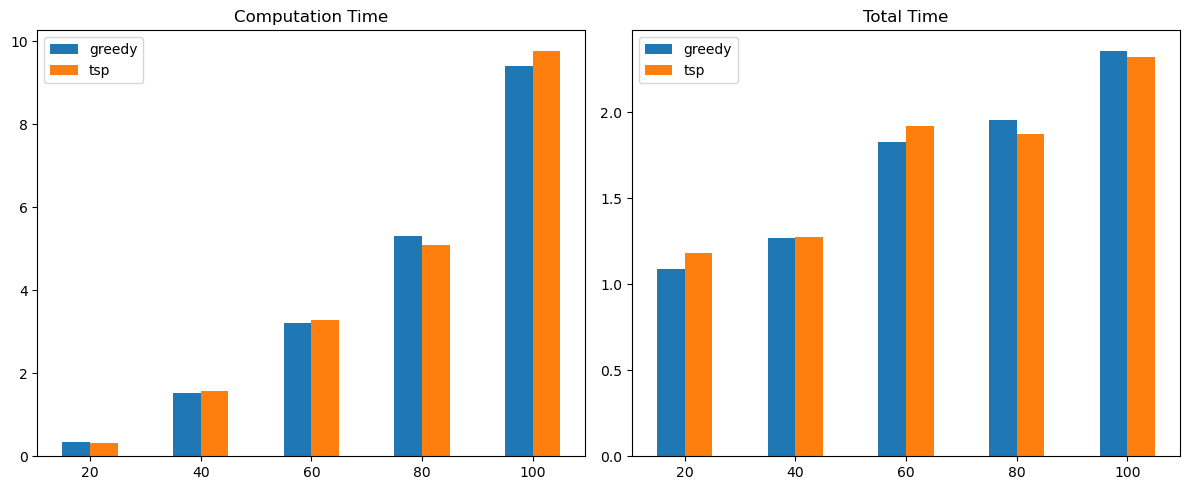

/var/folders/l8/ty1m6_3d2kq72tqy9qj5rgrc0000gn/T/ipykernel_14241/1133816746.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(iterations))


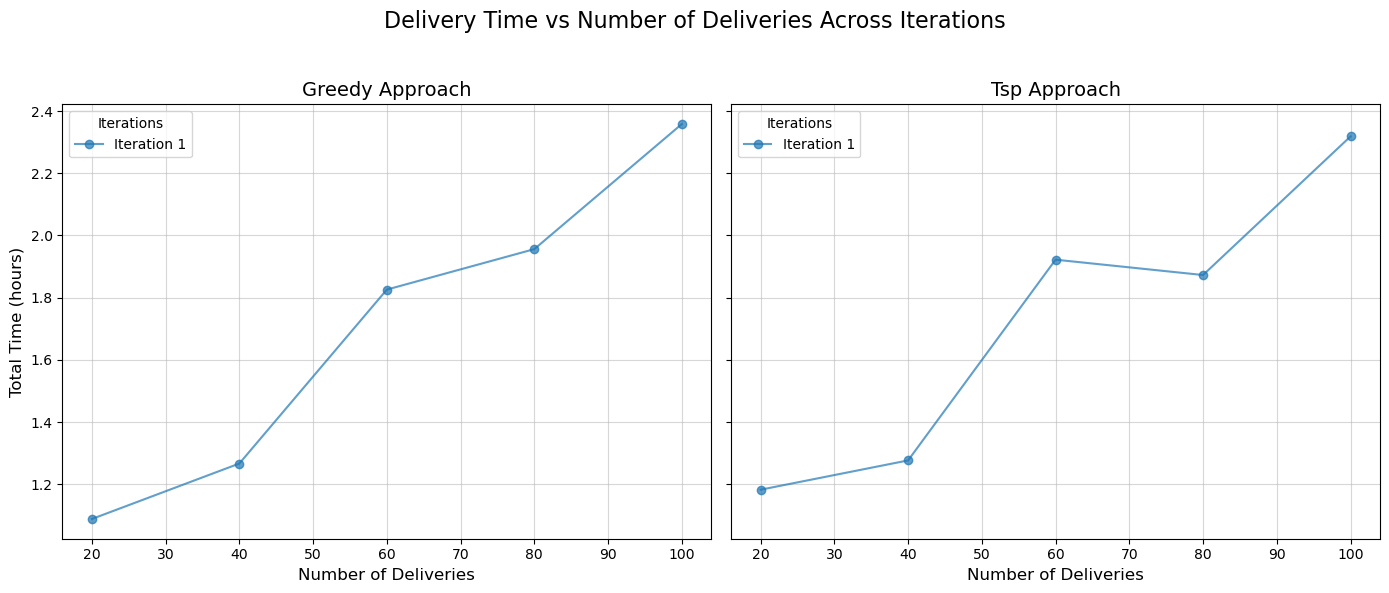

In [44]:
plot_comparison_time_and_comp(df)
plot_over_iterations(df)

## Conclusion

The results of this project indicate that two smaller trucks (B) working simultaneously are consistently more effective at delivering packages on time per day compared to one larger truck (A), particularly as the number of orders increases, supporting the Null Hypothesis. While the TSP approach (utilizing the larger truck) achieves better delivery times, it comes at a significantly higher computational cost. On the other hand, the Greedy approach (using smaller trucks) is more computationally efficient, making it a more practical solution for larger delivery volumes where computation time becomes a critical factor. Therefore, while the Alternate Hypothesis holds true for smaller delivery volumes where computation cost is less significant, the Null Hypothesis proves to be more practical and scalable for larger volumes due to its computational efficiency and reliability in meeting delivery demands.